# LU rozklad

## Bodová verze

$$
    A = L * U
$$
kde $L$ je dolní trojúhelníková matice s $l_{ii} = 1$ a $U$ je horní trojúhelníková matice.

Potom:
$$
    a_{ij} = \sum_{k=1}^{min(i,j)} l_{ik} u_{kj}.
$$

tedy:
\begin{eqnarray}
    l_{11} &=& 1, \\
    u_{11} &=& a_{11}, \\
    u_{1j} &=& a_{1j}, \\
    l_{i1} &=& a_{i1} / u_{11}, \\
    a_{ij} &=& \sum_{k=2}^{min(i,j)} l_{ik} u_{kj} + l_{i1} u_{1j}. 
\end{eqnarray}

## Bloková verze

\begin{eqnarray}
    A_{11} &=& L_{11} * U_{11}, \\
    A_{21} &=& L_{21} * U_{11}, \\
    A_{12} &=& L_{11} * U_{12}, \\
    A_{22} &=& L_{21} * U_{12} + L_{22} * U_{22}.
\end{eqnarray}

In [1]:
function testmatrix(n)
    A = zeros(n,n)
    for i=1:n, j=1:n
        A[i,j] = 2*n + min(i-j,j-i) 
    end
    return A
end;

In [2]:
A10 = testmatrix(10);
F=lufact(A10);
L=F[:L]

10x10 Array{Float64,2}:
 1.0   0.0       0.0       0.0       …  0.0       0.0       0.0      0.0
 0.95  1.0       0.0       0.0          0.0       0.0       0.0      0.0
 0.9   0.974359  1.0       0.0          0.0       0.0       0.0      0.0
 0.85  0.948718  0.973684  1.0          0.0       0.0       0.0      0.0
 0.8   0.923077  0.947368  0.972973     0.0       0.0       0.0      0.0
 0.75  0.897436  0.921053  0.945946  …  0.0       0.0       0.0      0.0
 0.7   0.871795  0.894737  0.918919     1.0       0.0       0.0      0.0
 0.65  0.846154  0.868421  0.891892     0.970588  1.0       0.0      0.0
 0.6   0.820513  0.842105  0.864865     0.941176  0.969697  1.0      0.0
 0.55  0.794872  0.815789  0.837838     0.911765  0.939394  0.96875  1.0

In [3]:
U=F[:U]

10x10 Array{Float64,2}:
 20.0  19.0   18.0      17.0      16.0      …  13.0      12.0      11.0    
  0.0   1.95   1.9       1.85      1.8          1.65      1.6       1.55   
  0.0   0.0    1.94872   1.89744   1.84615      1.69231   1.64103   1.58974
  0.0   0.0    0.0       1.94737   1.89474      1.73684   1.68421   1.63158
  0.0   0.0    0.0       0.0       1.94595      1.78378   1.72973   1.67568
  0.0   0.0    0.0       0.0       0.0      …   1.83333   1.77778   1.72222
  0.0   0.0    0.0       0.0       0.0          1.88571   1.82857   1.77143
  0.0   0.0    0.0       0.0       0.0          1.94118   1.88235   1.82353
  0.0   0.0    0.0       0.0       0.0          0.0       1.93939   1.87879
  0.0   0.0    0.0       0.0       0.0          0.0       0.0       1.9375 

In [4]:
function lu_pointwise!(A)
    n = size(A,1)
    for m=1:n
        for i=m+1:n
            A[i,m] /= A[m,m]
        end
        for i=m+1:n, j=m+1:n
            A[i,j] -= A[i,m]*A[m,j]
        end
    end
end;

In [5]:
A10=testmatrix(10);
lu_pointwise!(A10);
A10

10x10 Array{Float64,2}:
 20.0   19.0       18.0       17.0       …  13.0       12.0      11.0    
  0.95   1.95       1.9        1.85          1.65       1.6       1.55   
  0.9    0.974359   1.94872    1.89744       1.69231    1.64103   1.58974
  0.85   0.948718   0.973684   1.94737       1.73684    1.68421   1.63158
  0.8    0.923077   0.947368   0.972973      1.78378    1.72973   1.67568
  0.75   0.897436   0.921053   0.945946  …   1.83333    1.77778   1.72222
  0.7    0.871795   0.894737   0.918919      1.88571    1.82857   1.77143
  0.65   0.846154   0.868421   0.891892      1.94118    1.88235   1.82353
  0.6    0.820513   0.842105   0.864865      0.969697   1.93939   1.87879
  0.55   0.794872   0.815789   0.837838      0.939394   0.96875   1.9375 

In [6]:
function lu_block!(A)
    n = size(A,1)
    block=40
    
    for m=1:block:n
        mend = min(m+block-1,n)

        A_11 = sub(A, m:mend, m:mend)
        A_21 = sub(A, mend+1:n, m:mend)
        A_12 = sub(A, m:mend, mend+1:n)
        A_22 = sub(A, mend+1:n, mend+1:n)
        
        lu_pointwise!(A_11)
        
        L = tril(A_11,-1) + eye(A_11)
        U = triu(A_11)
        
        #A_21[:,:] = A_21 / U 
        LinAlg.BLAS.trsm!('R', 'U', 'N', 'N', 1.0, A_11, A_21)
        
        #A_12[:,:] = L \ A_12
        LinAlg.BLAS.trsm!('L', 'L', 'N', 'U', 1.0, A_11, A_12)
        
        #A_22[:,:] = A_22 - A_21 * A_12
        LinAlg.BLAS.gemm!('N', 'N', -1.0, A_21, A_12, 1.0, A_22)
    end
end;

In [7]:
A10=testmatrix(10);
lu_block!(A10);

In [8]:
function lu_openblas!(A)
    CblasColMajor = 102
    CblasNoTrans = 111
    ipiv = zeros(Int64, size(A,1))

    ccall( (:LAPACKE_dgetrf, "libopenblas"),
    Clonglong, 
    (Clonglong, Clonglong, Clonglong, 
    Ptr{Cdouble}, Clonglong, Ptr{Clonglong}),
    
    CblasColMajor, size(A,1), size(A,2), 
    A, size(A,1), ipiv)
end;

In [9]:
A10=testmatrix(10);
lu_openblas!(A10);
A10

10x10 Array{Float64,2}:
 20.0   19.0       18.0       17.0       …  13.0       12.0      11.0    
  0.95   1.95       1.9        1.85          1.65       1.6       1.55   
  0.9    0.974359   1.94872    1.89744       1.69231    1.64103   1.58974
  0.85   0.948718   0.973684   1.94737       1.73684    1.68421   1.63158
  0.8    0.923077   0.947368   0.972973      1.78378    1.72973   1.67568
  0.75   0.897436   0.921053   0.945946  …   1.83333    1.77778   1.72222
  0.7    0.871795   0.894737   0.918919      1.88571    1.82857   1.77143
  0.65   0.846154   0.868421   0.891892      1.94118    1.88235   1.82353
  0.6    0.820513   0.842105   0.864865      0.969697   1.93939   1.87879
  0.55   0.794872   0.815789   0.837838      0.939394   0.96875   1.9375 

In [10]:
function bench(fun)
    n = [11, 51, 101, 201, 501, 1001, 1501, 2001, 2501, 3001]
    t  = zeros(Float64, size(n))
    
    for i=1:size(n,1)
        A = testmatrix(n[i])
        
        t1 = time_ns()
        fun(A)
        t[i] = (time_ns() - t1) * 1.e-9
    end
    return t, n
end;

In [11]:
t_pointwise, n = bench(lu_pointwise!);

In [12]:
t_block, n = bench(lu_block!);

In [13]:
t_builtin, n = bench(lufact!);

In [14]:
t_openblas, n = bench(lu_openblas!);

In [15]:
using PyPlot;

In [24]:
mflops(t, n) = [ 1.e-6 * 2.0/3.0 * float(n[i])^3 / t[i] for i in 1:size(t,1)]

mflops (generic function with 1 method)

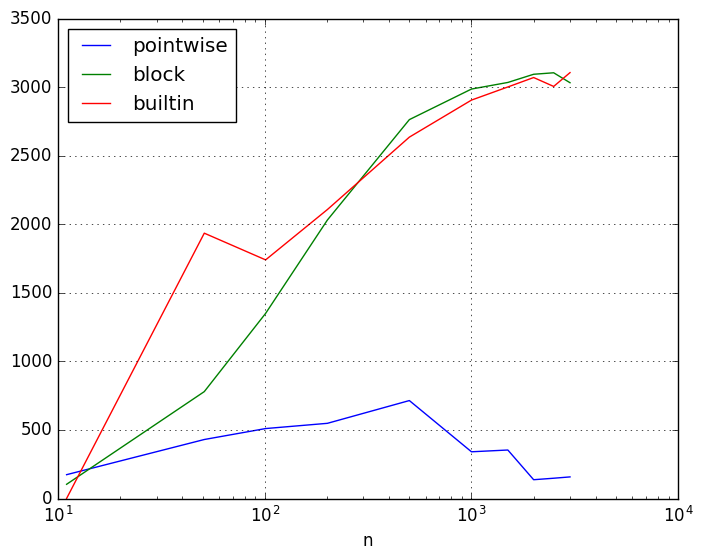

In [25]:
semilogx(n, mflops(t_pointwise,n), label="pointwise");
semilogx(n, mflops(t_block,n), label="block");
semilogx(n, mflops(t_builtin,n), label="builtin");
#semilogx(n, mflops(t_openblas,n), label="openblas");
legend(loc="upper left"); xlabel("n"); ylabel
grid(true);

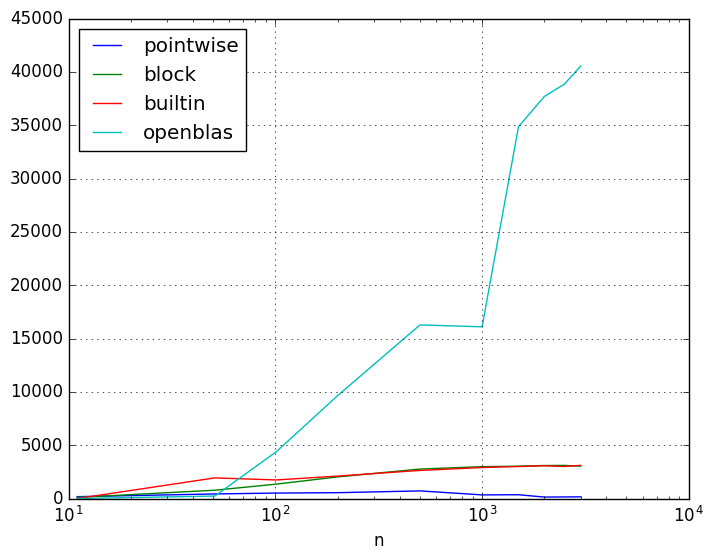

In [26]:
semilogx(n, mflops(t_pointwise,n), label="pointwise");
semilogx(n, mflops(t_block,n), label="block");
semilogx(n, mflops(t_builtin,n), label="builtin");
semilogx(n, mflops(t_openblas,n), label="openblas");
legend(loc="upper left"); xlabel("n"); ylabel
grid(true);